In [ ]:
student_id =  402300459
student_name = "Mohammadreza Bagheri"

print("your student id:", student_id)
print("your name:", student_name)

your student id: 402300459
your name: Mohammadreza Bagheri


## Setup Code
First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a deepHW2 folder and put all the files under Q1 folder, then 'deepHW2/Q1'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'deepHW3/Q1'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['cnn.py', '__pycache__', 'tripletCNN.ipynb']


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment.

In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

fully_connected_networks_path = os.path.join(GOOGLE_DRIVE_PATH, 'cnn.py')
fully_connected_networks_edit_time = time.ctime(os.path.getmtime(fully_connected_networks_path))
print('cnn.py last edited on %s' % fully_connected_networks_edit_time)

cnn.py last edited on Sat Dec 16 03:37:08 2023


**Part 1:**
First of all we import the required packages and libraries:

In [ ]:
import torch
import cnn
import torch.nn as nn
import torchvision
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from  torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
from torchvision.models import resnet50
from torch.utils.data import Dataset


Here, we load the resnet50 as our backbone model:

In [ ]:
model = models.resnet50(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:06<00:00, 14.8MB/s]


As we just want to train the FC layer, we freeze all the convolutional layers:

In [ ]:
for param in model.parameters():
  param.requires_grad  = False

In this part, we replace the FC layer of the model with a nn.Linear layer:

In [ ]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features,2)

preprocessing the CIFAR10 dataset to a two-class dataset:

In [ ]:
import cnn as cnn
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


batch_size = 128
trainset = cnn.dataset_preprocessing(trainset)
trainloader = DataLoader(trainset, batch_size, shuffle=True)

testset = cnn.dataset_preprocessing(testset)
testloader = DataLoader(testset, batch_size, shuffle=False)



100%|██████████| 170498071/170498071 [00:12<00:00, 13662613.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Here, we define the loss function and the model optimizer objects:

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
model, loss_epoch, acc_epoch, test_acc = cnn.trainTest_model(model,5,trainloader,testloader, optimizer,criterion,device)


Epoch: 1, finished.
Epoch: 2, finished.
Epoch: 3, finished.
Epoch: 4, finished.
Epoch: 5, finished.


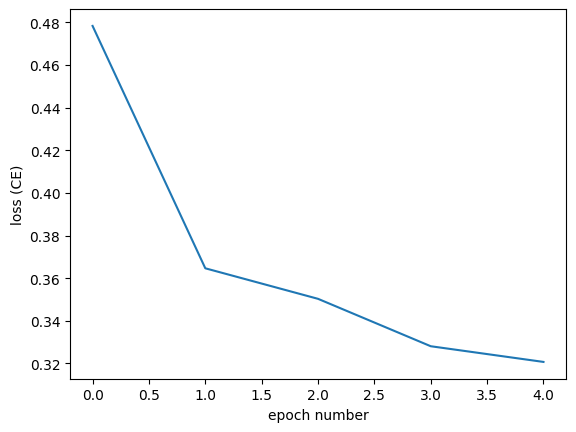

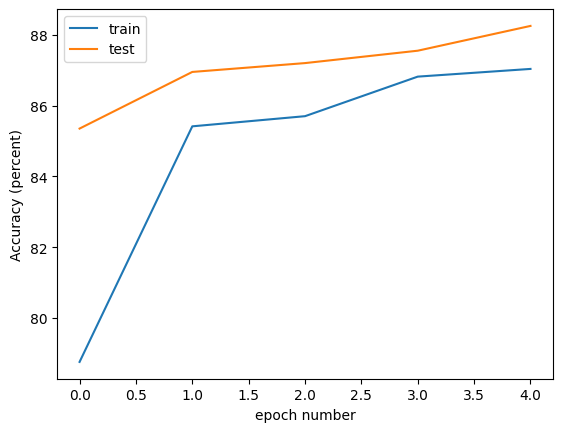

In [ ]:
epoch_idx = list(range(5))
plt.plot(epoch_idx, loss_epoch)
plt.ylabel("loss (CE)")
plt.xlabel("epoch number")
plt.show()

plt.plot(epoch_idx, acc_epoch,label = 'train')
plt.plot(epoch_idx, test_acc,label='test')
plt.legend(loc="upper left")
plt.ylabel("Accuracy (percent)")
plt.xlabel("epoch number")
plt.show()


**Part B:**
In this part we train the medel under triplet loss function.
Firstly, we create the required dataset by defining CustomDataset class:

Here, we initialize the model (resnet50):

In [ ]:
# Hyperparameters
batch_size = 12
learning_rate = 0.001
num_epochs = 5

# Data preprocessing
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter out the classes that their labels are greater than 1
a = []
for i in range(1000):
    a.append(train_dataset[i])


filtered_train_data = [(image, label) for image, label in a if label < 2]
filtered_test_data =  [(image, label) for image, label in test_dataset  if label < 2]

# create new dataset

train_dataset = torch.utils.data.TensorDataset(
    torch.stack([data[0] for data in filtered_train_data]),
    torch.tensor([data[1] for data in filtered_train_data])
)

test_dataset = torch.utils.data.TensorDataset(
    torch.stack([data[0] for data in filtered_test_data]),
    torch.tensor([data[1] for data in filtered_test_data])
)


# Create triplet dataset
triplet_train_dataset = cnn.customDataset(train_dataset)

# Create data loaders
train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Initialize the model
model = resnet50(pretrained=True)
model.fc = torch.nn.Identity()  # Remove FC layer


model = model.to(device)


criterion = nn.TripletMarginLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs =3
model = cnn.train_model_triplet(model,train_loader,num_epochs,device,optimizer,criterion)

Epoch 2: 100%|██████████| 18/18 [07:02<00:00, 23.46s/batch, loss=1.08]


After training the feature extractor, we train the classifier:

In [ ]:
for param in model.parameters():
  param.requires_grad  = False


model.fc = nn.Linear(2048,2)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
loss_epoch = []
acc_epoch = []
model = model.to(device)


model, loss_epoch, acc_epoch, test_acc = cnn.train_classifier_triplet(model, train_loader,test_loader, optimizer,criterion,device,num_epochs)





Epoch 4: 100%|██████████| 18/18 [00:50<00:00,  2.82s/batch, accuracy=80, loss=0.473]


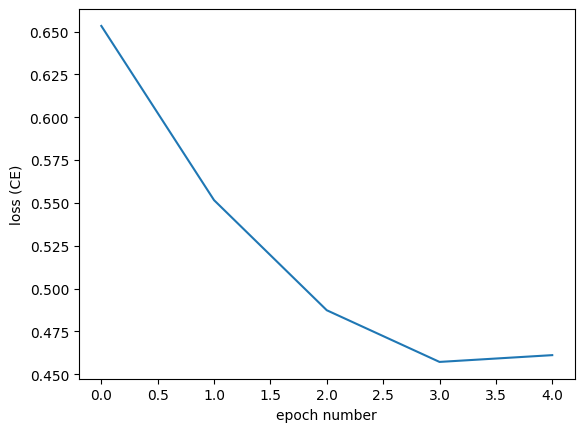

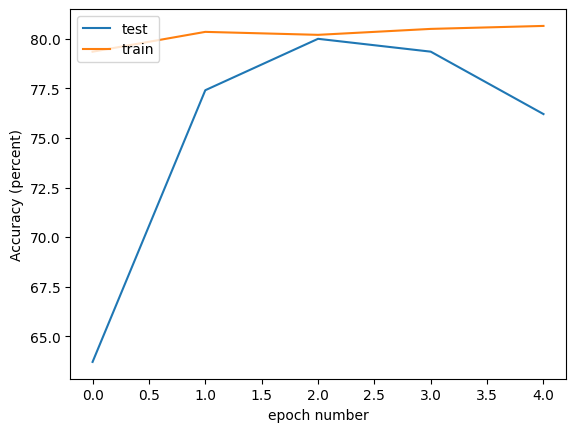

In [ ]:
epoch_idx = list(range(5))
plt.plot(epoch_idx, loss_epoch)
plt.ylabel("loss (CE)")
plt.xlabel("epoch number")
plt.show()

plt.plot(epoch_idx, acc_epoch,label = 'train')
plt.plot(epoch_idx, test_acc,label='test')
plt.legend(loc="upper left")
plt.ylabel("Accuracy (percent)")
plt.xlabel("epoch number")
plt.show()

final stage

In [ ]:
# Initialize the model
model = resnet50(pretrained=True)



model = model.to(device)

# Define the loss function
criterion_1 = nn.TripletMarginLoss()
criterion_2 = nn.CrossEntropyLoss()
# Set up the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
total_step = len(train_loader)

num_epochs =3

model, loss_epoch, acc_epoch, test_acc = cnn.train_model_triplet2(model,num_epochs,train_loader,test_loader,device,criterion_1,criterion_2,optimizer)





Epoch 2: 100%|██████████| 18/18 [06:51<00:00, 22.85s/batch, accuracy=90, loss=tensor(1.9623, grad_fn=<AddBackward0>)]


In [ ]:
# Test the network
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {(100 * correct / total):.2f}%')


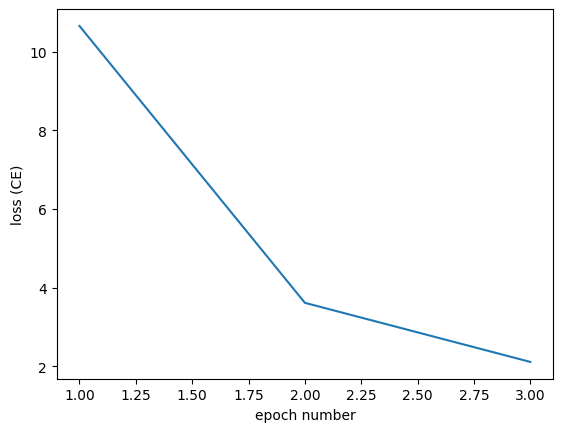

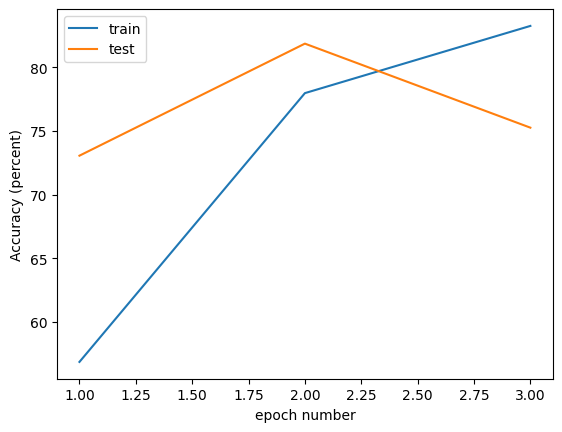

In [28]:
epoch_idx = [1,2,3]
plt.plot(epoch_idx, loss_epoch)
plt.ylabel("loss (CE)")
plt.xlabel("epoch number")
plt.show()

plt.plot(epoch_idx, acc_epoch,label = 'train')
plt.plot(epoch_idx, test_acc,label='test')
plt.legend(loc="upper left")
plt.ylabel("Accuracy (percent)")
plt.xlabel("epoch number")
plt.show()